In [1]:
from data_provider import data_factory,data_loader
import numpy as np
from torch.utils.data import DataLoader

In [2]:
import argparse
args = argparse.Namespace()
args.augmentation_ratio = 0    

In [3]:
train_set = data_loader.mDataset_test(args=[], root_path="dataset/btc", flag='train', size=[2,1,0],
                 features='MS', data_path='test.csv',
                 target='Y', scale=False, timeenc=0, freq='t', seasonal_patterns=None)
val_set = data_loader.mDataset_test(args=[], root_path="dataset/btc", flag='val', size=[2,1,0],
                 features='MS', data_path='test.csv',
                 target='Y', scale=False, timeenc=0, freq='t', seasonal_patterns=None)
test_set = data_loader.mDataset_test(args=[], root_path="dataset/btc", flag='test', size=[2,1,0],
                 features='MS', data_path='test.csv',
                 target='Y', scale=False, timeenc=0, freq='t', seasonal_patterns=None)

data: test.csv, scale False, seq_len 2,  self.label_len 1, self.pred_len 0
data: test.csv, scale False, seq_len 2,  self.label_len 1, self.pred_len 0
data: test.csv, scale False, seq_len 2,  self.label_len 1, self.pred_len 0


In [ ]:
test_set.data_x

array([[250, 350],
       [251, 351],
       [252, 352],
       [253, 353],
       [254, 354],
       [255, 355],
       [256, 356],
       [257, 357],
       [258, 358],
       [259, 359],
       [260, 360],
       [261, 361],
       [262, 362],
       [263, 363],
       [264, 364],
       [265, 365],
       [266, 366],
       [267, 367],
       [268, 368],
       [269, 369],
       [270, 370],
       [271, 371],
       [272, 372],
       [273, 373],
       [274, 374],
       [275, 375],
       [276, 376],
       [277, 377],
       [278, 378],
       [279, 379],
       [280, 380],
       [281, 381],
       [282, 382],
       [283, 383],
       [284, 384],
       [285, 385],
       [286, 386],
       [287, 387],
       [288, 388],
       [289, 389],
       [290, 390],
       [291, 391],
       [292, 392],
       [293, 393],
       [294, 394],
       [295, 395],
       [296, 396],
       [297, 397],
       [298, 398],
       [299, 399]])

In [ ]:
train_loader = DataLoader(
    train_set,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True)
val_loader = DataLoader(
    val_set,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True)
test_loader = DataLoader(
    test_set,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    drop_last=True)

In [ ]:
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_loader):
    print(f"-----------batch {i}------------\nbatch x\n{batch_x}\nbatch y\n{batch_y}")

-----------batch 0------------
batch x
tensor([[[206, 306],
         [207, 307]],

        [[226, 326],
         [227, 327]]])
batch y
tensor([[[107]],

        [[127]]])
-----------batch 1------------
batch x
tensor([[[224, 324],
         [225, 325]],

        [[216, 316],
         [217, 317]]])
batch y
tensor([[[125]],

        [[117]]])
-----------batch 2------------
batch x
tensor([[[210, 310],
         [211, 311]],

        [[220, 320],
         [221, 321]]])
batch y
tensor([[[111]],

        [[121]]])
-----------batch 3------------
batch x
tensor([[[204, 304],
         [205, 305]],

        [[208, 308],
         [209, 309]]])
batch y
tensor([[[105]],

        [[109]]])
-----------batch 4------------
batch x
tensor([[[212, 312],
         [213, 313]],

        [[222, 322],
         [223, 323]]])
batch y
tensor([[[113]],

        [[123]]])
-----------batch 5------------
batch x
tensor([[[202, 302],
         [203, 303]],

        [[200, 300],
         [201, 301]]])
batch y
tensor([[[

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np

def extract_data_from_text(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    blocks = []
    current_block = []
    for line in lines:
        if "Args in experiment:" in line and current_block:
            blocks.append(current_block)
            current_block = []
        current_block.append(line)
    if current_block:
        blocks.append(current_block)

    block_names = []
    avg_val_ic_values = []
    avg_test_ic_values = []
    std_val_ic_values = []
    std_test_ic_values = []

    for block in blocks:
        block_text = "".join(block)
        model_match = re.search(r"Model:\s*(\S+)", block_text)

        val_ic_matches = re.findall(r"val ic:\s*([0-9.-]+)", block_text)
        test_ic_matches = re.findall(r"test ic:\s*([0-9.-]+)", block_text)

        if model_match and val_ic_matches and test_ic_matches:
            block_names.append(model_match.group(1))
            val_ic_floats = [float(value) for value in val_ic_matches]
            test_ic_floats = [float(value) for value in test_ic_matches]

            avg_val_ic_values.append(np.mean(val_ic_floats))
            avg_test_ic_values.append(np.mean(test_ic_floats))
            std_val_ic_values.append(np.std(val_ic_floats))
            std_test_ic_values.append(np.std(test_ic_floats))

    return block_names, avg_val_ic_values, avg_test_ic_values, std_val_ic_values, std_test_ic_values

def plot_ic_values(block_names, avg_val_ic_values, avg_test_ic_values, std_val_ic_values, std_test_ic_values):
    for i, name in enumerate(block_names):
        print(f'Block: {name}')
        print(f'Average val ic: {avg_val_ic_values[i]}, Std val ic: {std_val_ic_values[i]}')
        print(f'Average test ic: {avg_test_ic_values[i]}, Std test ic: {std_test_ic_values[i]}')
        print('-' * 50)

    plt.figure(figsize=(10, 6))

    for i, name in enumerate(block_names):
        plt.scatter(i, avg_val_ic_values[i], color='blue', label='val ic' if i == 0 else "")
        plt.scatter(i, avg_test_ic_values[i], color='red', label='test ic' if i == 0 else "")
        plt.text(i, avg_val_ic_values[i], f'{name}_val', fontsize=9, ha='right')
        plt.text(i, avg_test_ic_values[i], f'{name}_test', fontsize=9, ha='right')

    plt.xlabel("Block Index")
    plt.ylabel("IC Value")
    plt.title("Average val ic and test ic values for each block")
    plt.legend()
    plt.show()
file_path = 'log_overall_arch.txt'  # Replace with the actual file path

# block_names, avg_val_ic_values, avg_test_ic_values, std_val_ic_values, std_test_ic_values = extract_data_from_text(file_path)
# plot_ic_values(block_names, avg_val_ic_values, avg_test_ic_values, std_val_ic_values, std_test_ic_values)


In [ ]:
from models.MLPs import Baseline_5,Baseline_10,Baseline_15,Baseline_20,Baseline_25
import torch
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
from models.FFNs import LSTM_FFN

In [ ]:

class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.verbose = configs.verbose
        self.input_window_size = configs.seq_len
        self.label_len = configs.label_len
        self.kernel_size = configs.kernel_size
        self.num_filters = configs.num_kernels
        self.enc_in = configs.enc_in
        self.batch_size = configs.batch_size

        self.conv1_layers = nn.Conv1d(in_channels = 1, out_channels = self.num_filters, 
                                      kernel_size = self.kernel_size, dilation=1,padding ="same")
        self.dropout_conv1 = nn.Dropout(p=0.5)  # Dropout after first conv layer

        self.pool1d = nn.MaxPool1d(kernel_size=2)


        # Set print options 
        torch.set_printoptions(threshold=100, edgeitems=5)

        input_size = 20*self.num_filters*self.enc_in//2
        # input_size = 4139
        LSTM_layers = 4
        hidden_size = 128
        print(f"input_size {input_size}")
        self.projection1 = nn.Linear(input_size, input_size//2)
        self.dropout_P = nn.Dropout(p=0.5)  # Dropout after first conv layer

        self.lstm = nn.LSTM(input_size=input_size//2, 
                            hidden_size=hidden_size, 
                            num_layers=LSTM_layers, 
                            batch_first=True,
                            dropout=0.5)

        self.output_layer = nn.Linear(hidden_size, self.label_len)

    def patch_conv(self, inputs, window_size=20, stride=1):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        conved = torch.tensor([]).to("cpu")
        # n, x, y = inputs.shape
        for i in range(0, 30 - window_size, stride):
            slice_ = inputs[:, i:i + window_size, :]
            # print(f"shape of current slice {slice_.shape}")

            sampled = self.t_sampling(slice_)
            # print(f"shape of convoulted slice {sampled.shape}")
            sampled = self.projection1(sampled)
            sampled = self.dropout_P(sampled)

            conved = torch.cat([conved,sampled],dim=1)
        return conved
    
    def t_sampling(self,inputs):
        flattened_input = inputs.view(2, 1, -1)
        convoluted = self.conv1_layers(flattened_input)
        convoluted = self.dropout_conv1(convoluted)
        convoluted = convoluted.view(2,1,-1)
        convoluted = self.pool1d(convoluted)

        return convoluted
    
    def forward(self, inputs):
        convoluted = self.patch_conv(inputs)
        # print(f"shape of before lstm {convoluted.shape}")

        output = self.lstm(convoluted)[1][0]

        output = output.permute(1,0,2)[:,-1:,:]
        # print(f"shape of lstm {output.shape}")

        output = self.output_layer(output)
        # print(f"shape of output {output.shape}")

        return output

In [ ]:
import argparse
args = argparse.Namespace()
args.verbose = 0   
args.seq_len = 30 
args.label_len = 1
args.batch_size = 128  
args.kernel_size = 2
args.num_kernels = 2   
args.enc_in = 138

In [ ]:
from torchinfo import summary


In [ ]:
model = Model(args)
summary(model,input_size=(2, 30, 138), device="cpu") 

input_size 2760


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [2, 1, 1]                 --
├─Conv1d: 1-1                            [2, 2, 2760]              6
├─Dropout: 1-2                           [2, 2, 2760]              --
├─MaxPool1d: 1-3                         [2, 1, 2760]              --
├─Linear: 1-4                            [2, 1, 1380]              3,810,180
├─Dropout: 1-5                           [2, 1, 1380]              --
├─Conv1d: 1-6                            [2, 2, 2760]              (recursive)
├─Dropout: 1-7                           [2, 2, 2760]              --
├─MaxPool1d: 1-8                         [2, 1, 2760]              --
├─Linear: 1-9                            [2, 1, 1380]              (recursive)
├─Dropout: 1-10                          [2, 1, 1380]              --
├─Conv1d: 1-11                           [2, 2, 2760]              (recursive)
├─Dropout: 1-12                          [2, 2, 2760

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(model)}")

Number of parameters: 4979723


In [ ]:
train_set = data_loader.mDataset_test(args=[], root_path="dataset/btc", flag='train', size=[2,1,0],
                 features='MS', data_path='btc_train.csv',
                 target='Y', scale=False, timeenc=0, freq='t', seasonal_patterns=None)

In [6]:
train_set = pd.read_csv("dataset/btc/btc_train.csv")

In [7]:
train_set

,time,timestamp,open,high,low,close,range5,x0,x1,x2,...,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137
0,2022-04-01 00:01:00,1648771260000,45513.25,45549.95,45451.45,45474.05,0.002446,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2022-04-01 00:02:00,1648771320000,45468.05,45469.95,45422.05,45422.05,0.003179,-0.000173,-0.000069,-0.000036,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,2022-04-01 00:03:00,1648771380000,45422.05,45549.95,45422.05,45549.95,0.000970,0.000169,0.000045,0.000020,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,2022-04-01 00:04:00,1648771440000,45549.95,45565.95,45494.05,45513.85,0.001149,0.000225,0.000090,0.000046,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,2022-04-01 00:05:00,1648771500000,45513.85,45559.95,45512.05,45557.45,0.000799,0.000387,0.000184,0.000100,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442070,2024-01-01 23:51:00,1704153060000,44076.35,44107.65,44076.35,44106.15,0.001182,0.000195,0.001603,0.002784,...,-0.044537,-1.0,0.114387,0.300000,-0.013208,0.010405,0.031905,0.013680,0.024515,1.0
442071,2024-01-01 23:52:00,1704153120000,44106.15,44153.70,44100.35,44153.70,-0.000222,0.000381,0.001622,0.002808,...,-0.054130,-1.0,0.104585,0.266667,-0.043996,0.020457,0.028704,0.012070,0.022071,1.0
442072,2024-01-01 23:53:00,1704153180000,44153.40,44195.95,44145.25,44145.25,0.000036,0.000431,0.001612,0.002817,...,-0.060471,-1.0,0.094510,0.233333,-0.069820,0.033018,0.025024,0.010266,0.019241,1.0
442073,2024-01-01 23:54:00,1704153240000,44150.20,44156.45,44109.70,44147.85,0.000049,0.000440,0.001595,0.002821,...,-0.064040,-1.0,0.085921,0.200000,-0.095072,0.042051,0.021225,0.008607,0.016383,1.0


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Model(tf.keras.Model):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.verbose = configs.verbose
        self.input_window_size = configs.seq_len
        self.label_len = configs.label_len
        self.kernel_size = configs.kernel_size
        self.num_filters = configs.num_kernels
        self.enc_in = configs.enc_in
        self.batch_size = configs.batch_size

        self.conv1_layers = layers.Conv1D(filters=self.num_filters, 
                                          kernel_size=self.kernel_size, 
                                          padding="same",
                                          activation=None)
        self.dropout_conv1 = layers.Dropout(rate=0.5)

        self.pool1d = layers.MaxPooling1D(pool_size=2)

        input_size = 20 * self.num_filters * self.enc_in // 2

        self.projection1 = layers.Dense(units=input_size // 2, activation=None)
        self.dropout_P = layers.Dropout(rate=0.5)

        self.lstm = layers.LSTM(units=128, 
                                return_sequences=True,
                                dropout=0.5,
                                recurrent_dropout=0.5)

        self.output_layer = layers.Dense(units=self.label_len)

    def patch_conv(self, inputs, window_size=20, stride=1):
        conved = tf.constant([])
        for i in range(0, 30 - window_size, stride):
            slice_ = inputs[:, i:i + window_size, :]
            sampled = self.t_sampling(slice_)
            sampled = self.projection1(sampled)
            sampled = self.dropout_P(sampled)
            conved = tf.concat([conved, sampled], axis=1)
        return conved
    
    def t_sampling(self, inputs):
        flattened_input = tf.reshape(inputs, (2, 1, -1))
        convoluted = self.conv1_layers(flattened_input)
        convoluted = self.dropout_conv1(convoluted)
        convoluted = tf.reshape(convoluted, (2, 1, -1))
        convoluted = self.pool1d(convoluted)
        return convoluted

    def call(self, inputs):
        convoluted = self.patch_conv(inputs)
        output = self.lstm(convoluted)
        output = output[:, -1, :]
        output = self.output_layer(output)
        return output


2024-08-12 18:32:39.443811: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 18:32:40.273366: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import argparse
args = argparse.Namespace()
args.verbose = 0   
args.seq_len = 30 
args.label_len = 1
args.batch_size = 128  
args.kernel_size = 2
args.num_kernels = 2   
args.enc_in = 138

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the input
input_tensor = tf.keras.Input(shape=(1, 2760),name='input_layer')

# 1D Convolutional Layer
conv1d_layer = layers.Conv1D(filters=2, kernel_size=2, padding='same',data_format='channels_first', name='1d_convolution')(input_tensor)

# Reshape the input tensor to (128, 2 * 2760)
reshaped_input = layers.Reshape((2 * 2760,))(conv1d_layer)

# Apply Dense layer to project to 10 channels
dense_layer = layers.Dense(10 * 2760)(reshaped_input)

# Reshape back to (128, 10, 2760)
projected_tensor = layers.Reshape((10, 2760))(dense_layer)

linear_layer = layers.Dense(1380,name="projection")(projected_tensor)

# 4-Layer LSTM Block
# lstm_input = tf.tile(linear_layer, [1, 10, 1])  # Tile to expand to (128, 10, 1380)
lstm_layer = layers.GRU(128, return_sequences=True)(linear_layer)
for _ in range(3):  # Adding the other 3 LSTM layers
    lstm_layer = layers.GRU(128, return_sequences=True)(lstm_layer)


reshaped_output = layers.Reshape((10*128,))(lstm_layer)

# Apply Dense layer to project to 10 channels
dense_output_layer = layers.Dense(128)(reshaped_output)

# Reshape back to (128, 10, 2760)
projected_output_tensor = layers.Reshape((1, 128))(dense_output_layer)


# Output Linear Layer to map 128X1X128 to 128X1X1
output_projection = layers.Dense(1,name="ouput")(projected_output_tensor)

# Build the model
model = Model(inputs=input_tensor, outputs=output_projection)

# Print the model summary
model.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 
 reshape_19 (Reshape)        (None, 5520)              0         
                                                                 
 dense_27 (Dense)            (None, 27600)             152379600 
                                                                 
 reshape_20 (Reshape)        (None, 10, 2760)          0         
                                                                 
 projection (Dense)          (None, 10, 1380)          3810180   
                                                                 
 gru (GRU)                   (None, 10, 128)           579

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the input
input_tensor = tf.keras.Input(shape=(1, 2760),name='input_layer')

# 1D Convolutional Layer
conv1d_layer = layers.Conv1D(filters=2, kernel_size=2, padding='same',data_format='channels_first', name='1d_convolution')(input_tensor)

# Reshape the input tensor to (128, 2 * 2760)
reshaped_input = layers.Reshape((2 * 2760,))(conv1d_layer)

# Apply Dense layer to project to 10 channels
dense_layer = layers.Dense(10 * 2760)(reshaped_input)

# Reshape back to (128, 10, 2760)
projected_tensor = layers.Reshape((10, 2760))(dense_layer)

# linear_layer = layers.Dense(1380,name="projection")(projected_tensor)

# 4-Layer LSTM Block
# lstm_input = tf.tile(linear_layer, [1, 10, 1])  # Tile to expand to (128, 10, 1380)
lstm_layer = layers.GRU(128, return_sequences=True)(projected_tensor)
for _ in range(3):  # Adding the other 3 LSTM layers
    lstm_layer = layers.GRU(128, return_sequences=True)(lstm_layer)


reshaped_output = layers.Reshape((10*128,))(lstm_layer)

# Apply Dense layer to project to 10 channels
dense_output_layer = layers.Dense(128)(reshaped_output)

# Reshape back to (128, 10, 2760)
projected_output_tensor = layers.Reshape((1, 128))(dense_output_layer)


# Output Linear Layer to map 128X1X128 to 128X1X1
output_projection = layers.Dense(1,name="ouput")(projected_output_tensor)

# Build the model
model = Model(inputs=input_tensor, outputs=output_projection)

# Print the model summary
model.summary()


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 
 reshape_39 (Reshape)        (None, 5520)              0         
                                                                 
 dense_37 (Dense)            (None, 27600)             152379600 
                                                                 
 reshape_40 (Reshape)        (None, 10, 2760)          0         
                                                                 
 gru_12 (GRU)                (None, 10, 128)           1109760   
                                                                 
 gru_13 (GRU)                (None, 10, 128)           990

In [1]:
import numpy as np
np.corrcoef

AttributeError: module 'numpy' has no attribute 'corrcoe'

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the input
input_tensor = tf.keras.Input(shape=(1, 2760),name='input_layer')

# 1D Convolutional Layer
conv1d_layer = layers.Conv1D(filters=2, kernel_size=2, padding='same',data_format='channels_first', name='1d_convolution')(input_tensor)

# Reshape the input tensor to (128, 2 * 2760)
reshaped_input = layers.Reshape((2 * 2760,))(conv1d_layer)

# Apply Dense layer to project to 10 channels
dense_layer = layers.Dense(10 * 2760)(reshaped_input)

# Reshape back to (128, 10, 2760)
projected_tensor = layers.Reshape((10, 2760))(dense_layer)

linear_layer = layers.Dense(1380,name="projection")(projected_tensor)

# 4-Layer LSTM Block
# lstm_input = tf.tile(linear_layer, [1, 10, 1])  # Tile to expand to (128, 10, 1380)
lstm_layer = layers.LSTM(128, return_sequences=True)(linear_layer)
for _ in range(3):  # Adding the other 3 LSTM layers
    lstm_layer = layers.LSTM(128, return_sequences=True)(lstm_layer)


reshaped_output = layers.Reshape((10*128,))(lstm_layer)

# Apply Dense layer to project to 10 channels
dense_output_layer = layers.Dense(128)(reshaped_output)

# Reshape back to (128, 10, 2760)
projected_output_tensor = layers.Reshape((1, 128))(dense_output_layer)


# Output Linear Layer to map 128X1X128 to 128X1X1
output_projection = layers.Dense(1,name="ouput")(projected_output_tensor)

# Build the model
model = Model(inputs=input_tensor, outputs=output_projection)

# Print the model summary
model.summary()


Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 
 reshape_23 (Reshape)        (None, 5520)              0         
                                                                 
 dense_29 (Dense)            (None, 27600)             152379600 
                                                                 
 reshape_24 (Reshape)        (None, 10, 2760)          0         
                                                                 
 projection (Dense)          (None, 10, 1380)          3810180   
                                                                 
 lstm_48 (LSTM)              (None, 10, 128)           772

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the input
input_tensor = tf.keras.Input(shape=(1, 2760),name='input_layer')

# 1D Convolutional Layer
conv1d_layer = layers.Conv1D(filters=2, kernel_size=2, padding='same',data_format='channels_first', name='1d_convolution')(input_tensor)

# Reshape the input tensor to (128, 2 * 2760)
reshaped_input = layers.Reshape((2 * 2760,))(conv1d_layer)

# Apply Dense layer to project to 10 channels
dense_layer = layers.Dense(10 * 2760)(reshaped_input)

# Reshape back to (128, 10, 2760)
projected_tensor = layers.Reshape((10, 2760))(dense_layer)

# linear_layer = layers.Dense(1380,name="projection")(projected_tensor)

# 4-Layer LSTM Block
# lstm_input = tf.tile(linear_layer, [1, 10, 1])  # Tile to expand to (128, 10, 1380)
lstm_layer = layers.LSTM(128, return_sequences=True)(projected_tensor)
for _ in range(3):  # Adding the other 3 LSTM layers
    lstm_layer = layers.LSTM(128, return_sequences=True)(lstm_layer)


reshaped_output = layers.Reshape((10*128,))(lstm_layer)

# Apply Dense layer to project to 10 channels
dense_output_layer = layers.Dense(128)(reshaped_output)

# Reshape back to (128, 10, 2760)
projected_output_tensor = layers.Reshape((1, 128))(dense_output_layer)


# Output Linear Layer to map 128X1X128 to 128X1X1
output_projection = layers.Dense(1,name="ouput")(projected_output_tensor)

# Build the model
model = Model(inputs=input_tensor, outputs=output_projection)

# Print the model summary
model.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 
 reshape_35 (Reshape)        (None, 5520)              0         
                                                                 
 dense_35 (Dense)            (None, 27600)             152379600 
                                                                 
 reshape_36 (Reshape)        (None, 10, 2760)          0         
                                                                 
 lstm_52 (LSTM)              (None, 10, 128)           1479168   
                                                                 
 lstm_53 (LSTM)              (None, 10, 128)           131

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define the input
input_tensor = tf.keras.Input(shape=(1, 2760),name='input_layer')

# 1D Convolutional Layer
conv1d_layer = layers.Conv1D(filters=2, kernel_size=2, padding='same',data_format='channels_first', name='1d_convolution')(input_tensor)

# Reshape the input tensor to (128, 2 * 2760)
reshaped_input = layers.Reshape((2 * 2760,))(conv1d_layer)

# Apply Dense layer to project to 10 channels
dense_layer = layers.Dense(10 * 2760)(reshaped_input)

# Reshape back to (128, 10, 2760)
projected_tensor = layers.Reshape((10, 2760))(dense_layer)

linear_layer = layers.Dense(1380,name="projection")(projected_tensor)

# 4-Layer LSTM Block
# lstm_input = tf.tile(linear_layer, [1, 10, 1])  # Tile to expand to (128, 10, 1380)
lstm_layer = layers.SimpleRNN(128, return_sequences=True)(linear_layer)
for _ in range(3):  # Adding the other 3 LSTM layers
    lstm_layer = layers.SimpleRNN(128, return_sequences=True)(lstm_layer)


reshaped_output = layers.Reshape((10*128,))(lstm_layer)

# Apply Dense layer to project to 10 channels
dense_output_layer = layers.Dense(128)(reshaped_output)

# Reshape back to (128, 10, 2760)
projected_output_tensor = layers.Reshape((1, 128))(dense_output_layer)


# Output Linear Layer to map 128X1X128 to 128X1X1
output_projection = layers.Dense(1,name="ouput")(projected_output_tensor)

# Build the model
model = Model(inputs=input_tensor, outputs=output_projection)

# Print the model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 
 reshape_8 (Reshape)         (None, 5520)              0         
                                                                 
 dense_4 (Dense)             (None, 27600)             152379600 
                                                                 
 reshape_9 (Reshape)         (None, 10, 2760)          0         
                                                                 
 projection (Dense)          (None, 10, 1380)          3810180   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10, 128)           1931

Model: "LSTM without projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 
   
                                                                
                                                                 
 reshape_36 (Reshape)        (None, 10, 2760)          0         
                                                                 
 lstm_52 (LSTM)              (None, 10, 128)           1479168   
                                                                 
 lstm_53 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_54 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_55 (LSTM)              (None, 10, 128)           131584    
                                                                 
  
                                                                 
                                                                 
 reshape_38 (Reshape)        (None, 1, 128)            0         
                                                                 
 ouput (Dense)               (None, 1, 1)              129       
                                                                 
=================================================================
Trainable params: 6+1479168+131584+131584+131584+129 = 1874055
_________________________________________________________________

Model: "LSTM with projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                                                                                      
                                                                 
 reshape_24 (Reshape)        (None, 10, 2760)          0         
                                                                 
 projection (Dense)          (None, 10, 1380)          3810180

                                                                 
 lstm_48 (LSTM)              (None, 10, 128)           772608    
                                                                 
 lstm_49 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_50 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_51 (LSTM)              (None, 10, 128)           131584    
                                                                 
                                                                 
 reshape_38 (Reshape)        (None, 1, 128)            0         
                                                                
 ouput (Dense)               (None, 1, 1)              129      

Trainable params: 4977675
_________________________________________________________________

Model: "GRU without projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         

                                                                 
 reshape_40 (Reshape)        (None, 10, 2760)          0         
                                                                 
 gru_12 (GRU)                (None, 10, 128)           1109760   
                                                                 
 gru_13 (GRU)                (None, 10, 128)           99072     
                                                                 
 gru_14 (GRU)                (None, 10, 128)           99072     
                                                                 
 gru_15 (GRU)                (None, 10, 128)           99072     
                                                                 

 reshape_38 (Reshape)        (None, 1, 128)            0         
                                                                
 ouput (Dense)               (None, 1, 1)              129  


Trainable params: 1407111

_________________________________________________________________

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 

                                                                 
 reshape_20 (Reshape)        (None, 10, 2760)          0         
                                                                 
 projection (Dense)          (None, 10, 1380)          3810180   

                                                                 
 gru (GRU)                   (None, 10, 128)           579840    
                                                                 
 gru_1 (GRU)                 (None, 10, 128)           99072     
                                                                 
 gru_2 (GRU)                 (None, 10, 128)           99072     
                                                                 
 gru_3 (GRU)                 (None, 10, 128)           99072     
                                                                 

                                                                 
 reshape_22 (Reshape)        (None, 1, 128)            0         
                                                                 
 ouput (Dense)               (None, 1, 1)              129       
                                                                 
=================================================================
Trainable params: 4687371
_________________________________________________________________

Model: "RNN with projection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 

                                                                 
 reshape_5 (Reshape)         (None, 10, 2760)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10, 128)           369792    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10, 128)           32896     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10, 128)           32896     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 10, 128)           32896     
                                                                 
 reshape_6 (Reshape)         (None, 1280)              0         
                                                                 
      
                                                                 
 ouput (Dense)               (None, 1, 1)              129       
                                                                 
=================================================================
Trainable params: 153012183 (583.70 MB)
_________________________________________________________________

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_layer (InputLayer)    [(None, 1, 2760)]         0         
                                                                 
 1d_convolution (Conv1D)     (None, 2, 2760)           6         
                                                                 

                                                                 
 reshape_9 (Reshape)         (None, 10, 2760)          0         
                                                                 
 projection (Dense)          (None, 10, 1380)          3810180   
 
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10, 128)           193152    
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10, 128)           32896     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 10, 128)           32896     
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 10, 128)           32896     
                                                                 

                                                                 
 reshape_11 (Reshape)        (None, 1, 128)            0         
                                                                 
 ouput (Dense)               (None, 1, 1)              129       
                                                                 
=================================================================
Trainable params: 
_________________________________________________________________

Total records
442075

Size
61006350

LSTM
1874055
4977675

GRU
1407111 
4687371 

RNN
468615
4102155


In [95]:
from data_provider import data_factory,data_loader
import numpy as np
from torch.utils.data import DataLoader
import argparse
args = argparse.Namespace()
args.augmentation_ratio = 0    
test_set = data_loader.mDataset_btc_block(args=[], root_path="dataset/btc", flag='test', size=[30,1,0],
                 features='MS', data_path='btc_t_v_withftc.csv',
                 target='range5', scale=True, timeenc=0, freq='t', seasonal_patterns=None)
test_loader = DataLoader(
    test_set,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    drop_last=True)

data: btc_t_v_withftc.csv, scale True, seq_len 30,  self.label_len 1, self.pred_len 0


In [96]:
len(test_set)

833

In [97]:
for i,(x,y,batch_x_mark,batch_y_mark) in enumerate(test_loader):
    print(i,y)

0 tensor([[[-0.7622]],

        [[-0.1370]],

        [[-0.0432]],

        [[-0.5039]],

        [[-0.7015]],

        [[ 0.8096]],

        [[-0.6092]],

        [[-0.9793]],

        [[-0.2222]],

        [[ 0.8766]],

        [[ 0.4902]],

        [[-1.3172]],

        [[ 1.0690]],

        [[ 0.7101]],

        [[ 0.3167]],

        [[ 0.4525]],

        [[ 0.3779]],

        [[ 0.5860]],

        [[-0.7317]],

        [[-1.2250]],

        [[-0.4307]],

        [[ 0.4614]],

        [[ 1.3150]],

        [[ 0.3738]],

        [[-0.2410]],

        [[ 0.3007]],

        [[ 0.4243]],

        [[ 0.8271]],

        [[-0.7470]],

        [[-0.4425]],

        [[-0.2958]],

        [[-0.6008]],

        [[ 0.6708]],

        [[ 0.9839]],

        [[ 0.5162]],

        [[-0.4187]],

        [[ 0.9131]],

        [[-0.3091]],

        [[ 2.0539]],

        [[ 1.7090]],

        [[-1.6276]],

        [[-0.3198]],

        [[ 0.3131]],

        [[ 0.6201]],

        [[-2.8204]],

        

In [112]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [141]:
df = pd.read_csv("/root/code/FinFusionNet/dataset/btc/btc_t_v_withftc.csv")

fix_seed = 2021
random.seed(fix_seed)
# torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

In [142]:
test_lbound = int(len(df)*0.5)
test_ubound =  int(len(df))//8*5
train_bound = int(len(df)*0.4)


In [143]:
factors = df.columns.drop(["time","timestamp"])
df_f = df[factors]
factors

Index(['range5', 'x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8',
       ...
       'x128', 'x129', 'x130', 'x131', 'x132', 'x133', 'x134', 'x135', 'x136',
       'x137'],
      dtype='object', length=139)

In [144]:
train = df_f[:train_bound]
test = df_f[test_lbound:test_ubound]

In [145]:
scalar = StandardScaler()
scalar.fit(train)
scaled_target = scalar.transform(test)[:,:1]

In [146]:
scaled_target = scaled_target[29::30]


In [147]:
scaled_target = scaled_target[:128*6]

In [148]:
len(scaled_target)

768

In [149]:
target_mean = np.mean(scaled_target)
target_std = np.std(scaled_target)
target_mean,target_std

(0.053040394362205916, 1.124386724262606)

In [150]:
scaled_target = scaled_target.reshape(1,-1)

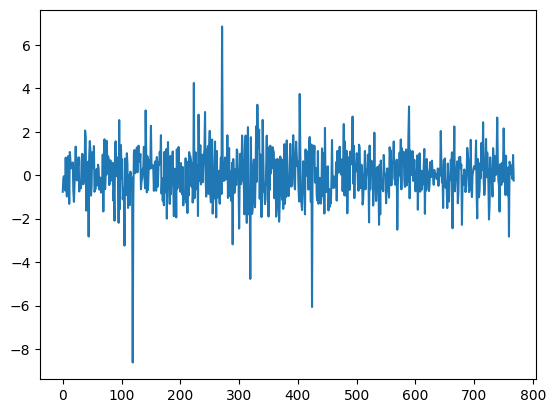

In [151]:
plt.plot(scaled_target.reshape(-1))

In [155]:
arr = np.random.laplace(loc=-0.005064991768449545, scale=0.00045447496813721955, size=768)
arr = arr.reshape(1,-1)
ic = np.corrcoef(arr,scaled_target)
ic

array([[1.        , 0.05772838],
       [0.05772838, 1.        ]])

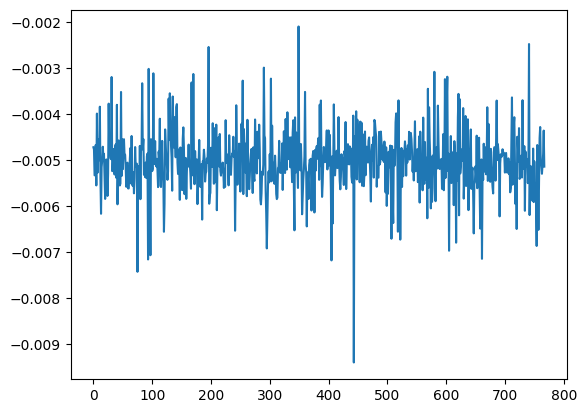

In [156]:
plt.plot(arr.reshape(-1))

In [183]:
arr = np.random.normal(loc=0.053040388971567154, scale=1.1251194477081299, size=768)
arr = arr.reshape(1,-1)
ic = np.corrcoef(arr,scaled_target)
ic

array([[1.        , 0.05443376],
       [0.05443376, 1.        ]])

test ic:  0.0857653817976751

-----------prediction------- 
tensor([-0.0052, -0.0054, -0.0057, -0.0057, -0.0057,  ..., -0.0054, -0.0056,
        -0.0046, -0.0044, -0.0053])

-----------Lables------- 
tensor([-0.7622, -0.1370, -0.0432, -0.5039, -0.7015,  ...,  0.4443, -0.0506,
        -0.1820,  0.9311, -0.2445])

mean of prediction -0.005064991768449545, std of prediction 0.00045447496813721955, len 768
mean of labels 0.053040388971567154, std of labels 1.1251194477081299, len 768